In [2]:
import scipy
import statsmodels
import sklearn
import theano
import tensorflow
import keras
import glob
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
import matplotlib.pyplot as plt

In [3]:
#read data
df = pd.read_csv('./Data/gill136_2021-02-01-0000_2021-02-08-0000.csv', index_col=False)
print(len(df))
df.columns

399852


Index(['Unix Timestamp [ms]', 'Time ISO', 'Time [US/Eastern]', 'Name',
       'Analysis - other - Average speed in service [mi/h]',
       'Analysis - fuel - Fuel used [gal]',
       'Analysis - other - Distance driven [mi]',
       'Vehicle - Acceleratorpedal Position [%]',
       'Vehicle - Ambient Air Temperature [°F]',
       'Engine - Engine Fuel Rate [gal/h]', 'Engine - Engine Speed [rpm]',
       'Vehicle - Wheel Based Vehicle Speed [mi/h]', 'GPS - Altitude [m]',
       'GPS - GPS position Latitude', 'GPS - GPS position Longitude'],
      dtype='object')

In [4]:
#process raw data
df['elevation']=0 #fix here
df['elevdiff']=df['elevation'].diff() #ft
df['elevdiff']=df['elevation']*0.000189394 #convert ft to mile
df['distdiff']=df['Analysis - other - Distance driven [mi]'].diff()
df['roadGrade']=df['elevdiff']/df['distdiff']
df['temp']=df['Vehicle - Ambient Air Temperature [°F]']
df['speed'] = df['Vehicle - Wheel Based Vehicle Speed [mi/h]']*1.60934 #convert to km/h
#interpolate if raw data is unfilled
FuelRate = df['Engine - Engine Fuel Rate [gal/h]']
FuelRate = FuelRate.interpolate()
df['FuelRate'] = FuelRate
Speed = df['speed']
Speed = Speed.interpolate()
df['speed'] = Speed
df=df[['speed','FuelRate']]

In [5]:
#calculate acceleration
speedms = df['speed']*1000/3600
df['acceleration']=speedms.diff() #unit: m/s^2
df = df.drop(df[df.FuelRate == 0].index)
df=df.dropna()

In [6]:
#split train and test datasets
train = df.sample(n=math.floor(0.8*df.shape[0]))
test = df.sample(n=math.ceil(0.2*df.shape[0]))

In [7]:
#build ann model
Y_train = train['FuelRate'] #unit: gal/h
X_train = train[['speed','acceleration']]
Y_test = test['FuelRate']
X_test = test[['speed','acceleration']]
model = Sequential()
model.add(Dense(6,kernel_initializer='normal', input_dim=2, activation ='relu'))
model.add(Dense(6, kernel_initializer='normal', activation ='relu'))
model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')

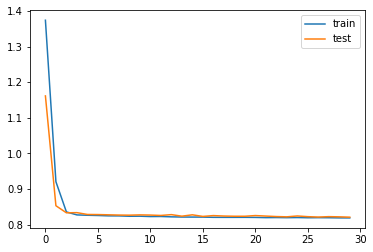

In [8]:
#fit model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=256, verbose = 0)
#performance
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
#predict all trips in a for loop
path = r'path/'                    
all_files = glob.glob(os.path.join(path, "Trajectory*.csv")) 
colnames=['time_ms','speed','acceleration','vehicle_ref','actorConfig_id','actorConfig_emissionClass','actorConfig_fuel','actorConfig_ref','actorConfig_vehicleClass']
for f in all_files:
#     print(f[65:72])
    trip=pd.read_csv(f,names=colnames, header=None)
    trip['speed']=trip['speed']*(0.01*3.6) 
    #km/h
    trip['acceleration']=trip['acceleration']*(0.001) 
    #m/s2
    input2esti=trip[['speed','acceleration']]
    #prdiction and plot results
    pre = model.predict(input2esti)
    tripf=pd.concat([trip,pd.DataFrame(pre,columns=['FuelRate'])], axis=1) 
    with open('./Data/diesel/' + 'diesel' + f[65:73] +'_'+ f[-12:-4] + '.csv', 'w', newline='') as oFile:
        tripf.to_csv(oFile, index = False)

In [9]:
#read trajectory data that needs prediction
trip = pd.read_csv("./Route1_trip151687020_065500.csv")
trip['speed']=trip['speed']*(0.01*3.6) 
#km/h
trip['acceleration']=trip['acceleration']*(0.001) 
#m/s2
input2esti=trip[['speed','acceleration']]


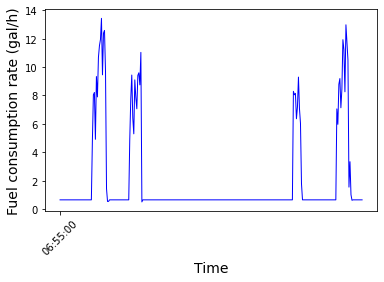

In [10]:
#prdiction and plot results
pre = model.predict(input2esti)

tripf=pd.concat([trip,pd.DataFrame(pre,columns=['FuelRate'])], axis=1) 

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(tripf.index, tripf.FuelRate, color='blue', linewidth=1)
ax1.set_xticks(tripf.index[::360])
ax1.set_xticklabels(tripf.time[::360], rotation=45)
plt.tight_layout(pad=4)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("Time",fontsize = 14)
plt.ylabel("Fuel consumption rate (gal/h)",fontsize = 14)
plt.show()